In [154]:
import artm

from topicnet.cooking_machine import Dataset
from topicnet.cooking_machine.cubes import (
    CubeCreator,
    GreedyStrategy,
    PerplexityStrategy,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.dataset import get_modality_vw
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.dataset_manager import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

import datetime

In [155]:
import os
import pandas as pd
import numpy as np
import json

In [156]:
df_train = pd.read_csv('./SMSS/training/SMSS__FULL.csv', header=None)
df_test = pd.read_csv('./SMSS/eval/SMSS__TEST.csv', header=None)

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [158]:

from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("<style>.container { width:90% !important; }</style>"))

In [159]:
from collections import Counter

In [160]:
def get_vw_text(text, text_id):
    count = Counter(text.split(' '))
    vw_text = f'doc_{text_id} |@text '
    for key, value in count.items():
        if len(key) != 0:
            vw_text += f'{key}:{value} '
    return vw_text[:-1]

In [161]:
from nltk.corpus import stopwords

In [162]:
def preprocess(text):
    text = text.replace(':', '').lower().replace('.', '').replace(',', '')
    return text

In [163]:
train_texts_tn = []
train_texts = [preprocess(text) for text in df_train.iloc[:,0]]
for i, text in enumerate(train_texts):
    vw_text = get_vw_text(text, i)
    text_dict = {'id':f'doc_{i}', 'raw_text':text, 'vw_text':vw_text}
    train_texts_tn.append(text_dict)
    
pd.DataFrame(train_texts_tn).to_csv('./train1.csv')
dataset_train = Dataset('./train1.csv')

In [164]:
test_texts_tn = []
test_texts = [preprocess(text) for text in df_test.iloc[:,0]]
for i, text in enumerate(test_texts):
    vw_text = get_vw_text(text, i)
    text_dict = {'id':f'doc_{i}', 'raw_text':text, 'vw_text':vw_text}
    test_texts_tn.append(text_dict)
    
pd.DataFrame(test_texts_tn).to_csv('./test1.csv')
dataset_test = Dataset('./test1.csv')

In [194]:
def get_cube(tau1, tau2, name, bck=0, topics=20):
    model_artm = init_simple_default_model(
        dataset=dataset_train,
        modalities_to_use={'@text'},
        main_modality='@text',
        specific_topics = topics,
        background_topics=bck
    )
    tm = TopicModel(model_artm)
    specific_topics = [t for t in tm.topic_names if "background" not in t]
    experiment = Experiment(
    experiment_id=name, save_path="experiments", topic_model=tm
    )
    
    my_first_cube = RegularizersModifierCube(separate_thread=False,
        num_iter=20,
        regularizer_parameters=[
            {
                'regularizer': artm.DecorrelatorPhiRegularizer(
                    name='decorrelation_phi', 
                    class_ids="@text", 
                    topic_names=specific_topics
                ),
                'tau_grid': tau1
            },
            {
                'regularizer': artm.SmoothSparsePhiRegularizer(
                    name="smsp_phi_specific",
                    class_ids="@text", 
                    topic_names=specific_topics
                ),
                'tau_grid': tau2
            },
        ],
        verbose=True
    )

    models = my_first_cube(tm, dataset_train)
    return experiment, model_artm, my_first_cube, models

In [195]:
y_train = np.asarray(df_train.iloc[:,1] == 'spam')
y_test = np.asarray(df_test.iloc[:,1] == 'spam')

In [196]:
def get_accuracy(dataset_train, y_train, dataset_test, y_test, model):
    X_train = model.get_theta(dataset=dataset_train).values.T
    X_test = model.get_theta(dataset=dataset_test).values.T
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

In [197]:
decorr_tau = [0., 0.005, 0.01, 0.015, 0.02, 0.025]
ss_tau = [-0.1, -0.05, 0., 0.05, 0.1]

100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


0.9353535353535355 0.2873563218390805


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


0.9353535353535355 0.26744186046511625


100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


0.9356136820925554 0.2352941176470588


100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


0.9352226720647773 0.29545454545454547


100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


0.9334677419354839 0.28571428571428575


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


0.9330628803245435 0.29545454545454547


Text(0, 0.5, 'F1-score')

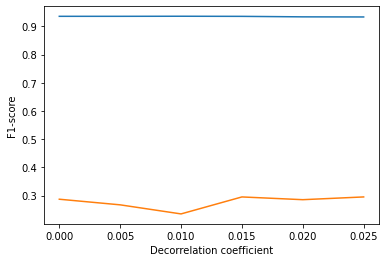

In [198]:
scores_train = []
scores_test = []
for i in decorr_tau:
    experiment, model_artm, cube, models = get_cube([i], [ss_tau[1]], f'{str(datetime.datetime.now())}_{i}', bck=0)
    model = list(experiment.models.values())[-1]
    model = model.restore()
    acc, f1_test = get_accuracy(dataset_train, y_train, dataset_test, y_test, model)
    acc, f1_train = get_accuracy(dataset_train, y_train, dataset_train, y_train, model)
    scores_train.append(f1_train)
    scores_test.append(f1_test)
    print(f1_train, f1_test)
plt.plot(decorr_tau, scores_train, label='Train')
plt.plot(decorr_tau, scores_test, label='Test')
plt.xlabel('Decorrelation coefficient')
plt.ylabel('F1-score')

100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


0.9357429718875501 0.2774566473988439


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


0.9346733668341708 0.2774566473988439


100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


0.9346733668341708 0.26744186046511625


100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


0.9348044132397192 0.3163841807909605


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


0.9342629482071714 0.34444444444444444


Text(0, 0.5, 'F1-score')

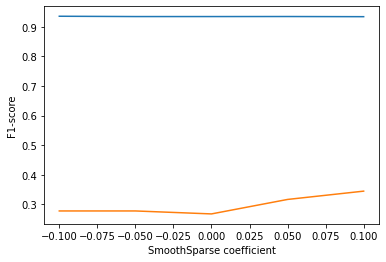

In [279]:
scores_train = []
scores_test = []
for i in ss_tau:
    experiment, model_artm, cube, models = get_cube([1e-3], [i], f'{str(datetime.datetime.now())}_{i}', bck=0)
    model = list(experiment.models.values())[-1]
    model = model.restore()
    acc, f1_test,_ = get_accuracy(dataset_train, y_train, dataset_test, y_test, model)
    acc, f1_train,_ = get_accuracy(dataset_train, y_train, dataset_train, y_train, model)
    scores_train.append(f1_train)
    scores_test.append(f1_test)
    print(f1_train, f1_test)
plt.plot(ss_tau, scores_train, label='Train')
plt.plot(ss_tau, scores_test)
plt.xlabel('SmoothSparse coefficient')
plt.ylabel('F1-score')

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


0.9342770475227502 0.3258426966292135


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


0.9346733668341708 0.34444444444444444


100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


0.9327902240325866 0.2873563218390805


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


0.9366834170854271 0.2873563218390805


100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


0.9364278506559032 0.3163841807909605


100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


0.9361702127659575 0.29714285714285715


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


0.9341438703140832 0.2774566473988439


Text(0, 0.5, 'F1-score')

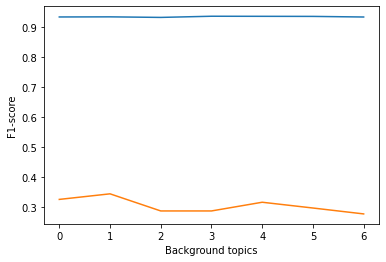

In [200]:
scores_train = []
scores_test = []
bck = np.arange(7)
for i in bck:
    experiment, model_artm, cube, models = get_cube([0.015], [0.05], f'{str(datetime.datetime.now())}_{i}', bck=i)
    model = list(experiment.models.values())[-1]
    model = model.restore()
    acc, f1_test = get_accuracy(dataset_train, y_train, dataset_test, y_test, model)
    acc, f1_train = get_accuracy(dataset_train, y_train, dataset_train, y_train, model)
    scores_train.append(f1_train)
    scores_test.append(f1_test)
    print(f1_train, f1_test)
plt.plot(bck, scores_train, label='Train')
plt.plot(bck, scores_test, label='Test')
plt.xlabel('Background topics')
plt.ylabel('F1-score')

In [229]:
experiment, model_artm, cube, models = get_cube([0.1, 0.015], [0.05], f'{str(datetime.datetime.now())}_{i}', bck=1, topics=20)

100%|██████████| 2/2 [00:12<00:00,  6.04s/it]


In [230]:
# for model in models:
#     model = model.restore()
#     acc, f1_test = get_accuracy(dataset_train, y_train, dataset_test, y_test, model)
#     acc, f1_train = get_accuracy(dataset_train, y_train, dataset_train, y_train, model)
#     print(f1_test, f1_train)

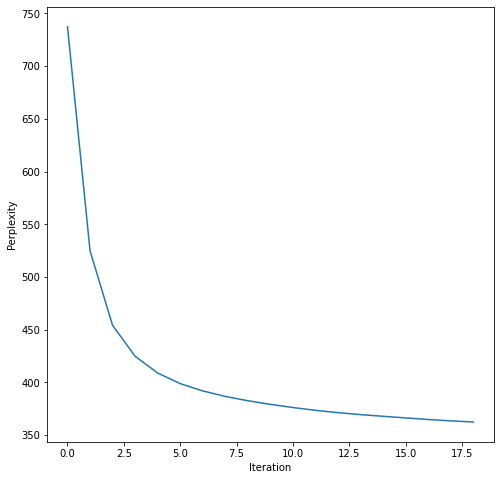

In [233]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))

for i, tm in enumerate(list(tms.values())[2:]):
    tm = tm.restore()
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:])
plt.xlabel('Iteration')
plt.ylabel('Perplexity')
plt.show()

In [234]:
thresh = 1e-5
best_model = list(experiment.models.values())[0]
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)

In [240]:
first_model_top_doc = TopDocumentsViewer(best_model, dataset=dataset_test).view()

In [263]:
[i[1] for i in first_model_top_tok.to_df().iloc[30:40].index]

['sugar',
 '5249',
 'tmr?',
 'jordan!txt',
 ';)',
 'bambling',
 'conducts',
 'potter',
 "ny's",
 'gua']

In [268]:
def get_accuracy(dataset_train, y_train, dataset_test, y_test, model):
    X_train = model.get_theta(dataset=dataset_train).values.T
    X_test = model.get_theta(dataset=dataset_test).values.T
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), clf

In [269]:
model = list(experiment.models.values())[-1]
model = model.restore()
acc, f1_test, clf = get_accuracy(dataset_train, y_train, dataset_test, y_test, model)
acc, f1_train, clf = get_accuracy(dataset_train, y_train, dataset_train, y_train, model)
scores_train.append(f1_train)
scores_test.append(f1_test)
print(f1_train, f1_test)

0.9340101522842639 0.34444444444444444


Text(0, 0.5, 'Topic importance')

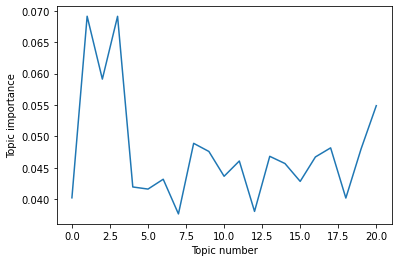

In [274]:
plt.plot(clf.feature_importances_)
plt.xlabel('Topic number')
plt.ylabel('Topic importance')